In [1]:
import abtem
import numpy as np
import matplotlib.pyplot as plt
import ase
from abtem import orthogonalize_cell
from ase.build import surface
from ase.io import read

(tutorials:structured_illumination)=
# Structured illumination

*ab*TEM supports various kinds of structured illumination for use with focused or parallel probes.

The code examples below were contributed by [Stephanie Ribet](https://github.com/smribet) based on work published in {cite}`ribet_shaping` and {cite}`zeltmann_bullseye`.

Let's first define a standard focused probe.

In [2]:
energy = 300e3
semiangle_cutoff = 6
extent = [128,128]
sampling = [0.2,0.2]

probe = abtem.Probe(
    energy = energy,
    extent = extent,
    sampling = sampling,
    semiangle_cutoff = semiangle_cutoff
);

Let's then define a Zernike phase plate as an instance of the more generic `RadialPhasePlate`, where we set the number of rings to be 1 (ie. only one empty central region) surrounded by another annular area up to the semiangle cutoff with the given phase shift of $\pi$.

In [28]:
zernike = abtem.transfer.RadialPhasePlate(
    num_rings = 1,
    central_semiangle = 2,
    phase_shift = np.pi,
    semiangle_cutoff = semiangle_cutoff, 
    energy = energy,
    extent = extent, 
    sampling = sampling
)

probe_zernike = abtem.Probe(
    energy = energy,
    extent = extent,
    sampling = sampling,
    semiangle_cutoff = semiangle_cutoff,
    aperture = zernike,
)

[########################################] | 100% Completed | 105.65 ms
[########################################] | 100% Completed | 103.10 ms


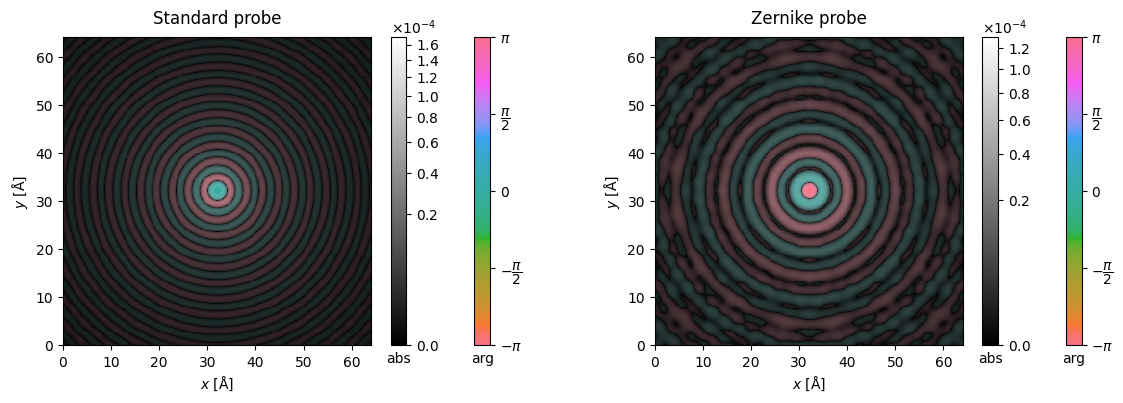

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
probe.build().complex_images().crop((64,64),(32,32)).show(ax=ax1, cbar=True, power=0.4, title="Standard probe");
probe_zernike.build().complex_images().crop((64,64),(32,32)).show(ax=ax2, cbar=True, power=0.4, title="Zernike probe");

In [31]:
probe_zernike.build().diffraction_patterns(max_angle=12)

## Bullseye aperture

So-called bullseye apertures can be defined with a dedicated transfer class in *ab*TEM, with a given number and width (in mrad) of "spokes" (radial connecting elements) and "rings" (azimuthal elements). In practice this is used as an aperture in `Probe` to define a bullseye probe.

In [433]:
bullseye = abtem.transfer.Bullseye(
    num_spokes = 4,
    num_rings = 3, 
    spoke_width = 10,
    ring_width = 1,
    semiangle_cutoff = semiangle_cutoff, 
    energy = energy,
    extent = extent, 
    sampling = sampling
)

probe_bullseye = abtem.Probe(
    energy = energy,
    extent = extent,
    sampling = sampling,
    semiangle_cutoff = semiangle_cutoff,
    aperture = bullseye
)

[########################################] | 100% Completed | 104.30 ms
[########################################] | 100% Completed | 101.92 ms


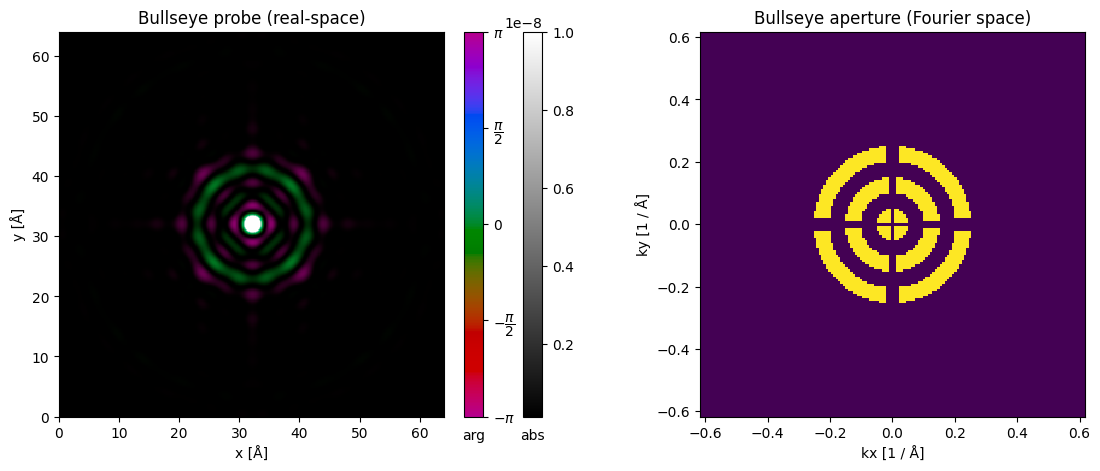

In [435]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
probe_bullseye.build().complex_images().crop((64,64),(32,32)).show(ax=ax1, vmax = 1e-8, cbar=True, title="Bullseye probe (real-space)")
probe_bullseye.build().diffraction_patterns(max_angle=12).show(ax=ax2, title="Bullseye aperture (Fourier space)");

## 4D-STEM with bullseye probe

Let's run an example simulation with a Ni slab.

Note that the real-space extent of the potential determines the reciprocal-space sampling of the diffraction patterns, hence the large number of repetitions!

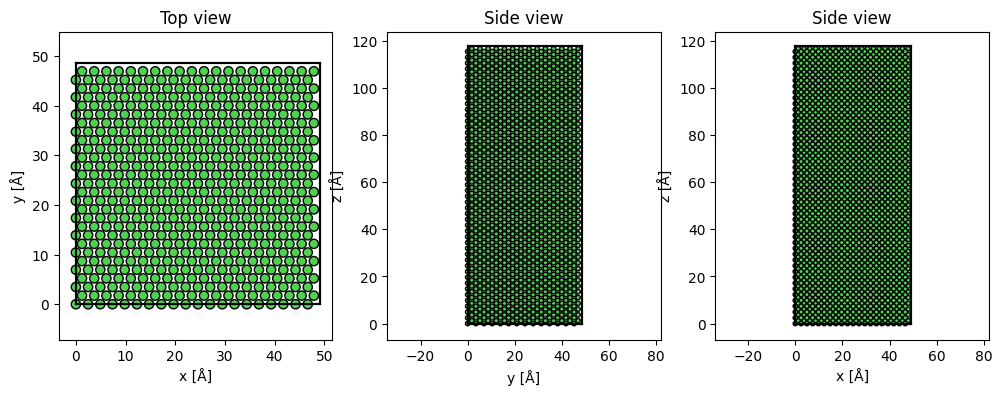

In [436]:
Ni_atoms = read("data/Ni.cif")
Ni_atoms = surface(Ni_atoms, (1, 1, 0), 4, periodic=True) 
repetitions = (10,14,12)

Ni_atoms *=repetitions

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

abtem.show_atoms(Ni_atoms, ax=ax1, title='Top view')
abtem.show_atoms(Ni_atoms, ax=ax2, plane='yz', title='Side view')
abtem.show_atoms(Ni_atoms, ax=ax3, plane='xz', title='Side view');

Adding frozen phonons to the potential; if we did not use them we could use `CrystalPotential` instead of repeating the model above.

In [437]:
frozen_phonons = abtem.FrozenPhonons(Ni_atoms, 12, 0.1)

potential = abtem.Potential(
    frozen_phonons,
    sampling=0.2
)

Scanning a grid over one unit cell of the potential with a full 2D pixelated detector.

In [438]:
scan_end = (potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1]) # Scan over one unit cell.

gridscan = abtem.GridScan(start=[0, 0], end=scan_end, sampling=1.0)

detector = abtem.PixelatedDetector(max_angle='valid', resample='uniform')

measurement = probe_bullseye.scan(
    potential=potential, 
    scan=gridscan, 
    detectors=detector, 
).compute()

[########################################] | 100% Completed | 17.73 ss


A single diffraction pattern selected from the scan shows the effect of the aperture.

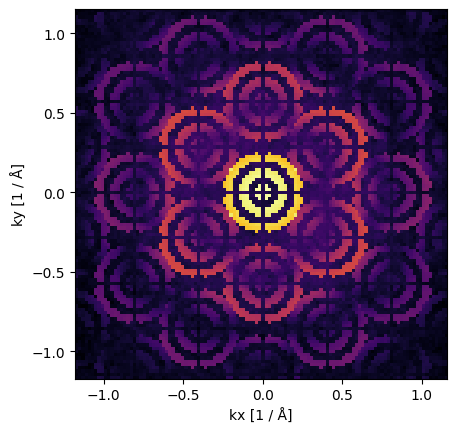

In [439]:
measurement[0, 0].show(cmap='inferno', power=0.2);

## Vortex beams

We can also define vortex beams with a given quantum number, resulting in variation of the complex phase around the azimuthal direction of the probe.

In [440]:
vortex = abtem.transfer.Vortex(
    quantum_number = 4,
    semiangle_cutoff = semiangle_cutoff, 
    energy = energy,
    extent = extent, 
    sampling = sampling
)

probe_vortex = abtem.Probe(
    energy = energy,
    extent = extent,
    sampling = sampling,
    aperture = vortex, 
    semiangle_cutoff = semiangle_cutoff
)

[########################################] | 100% Completed | 105.81 ms


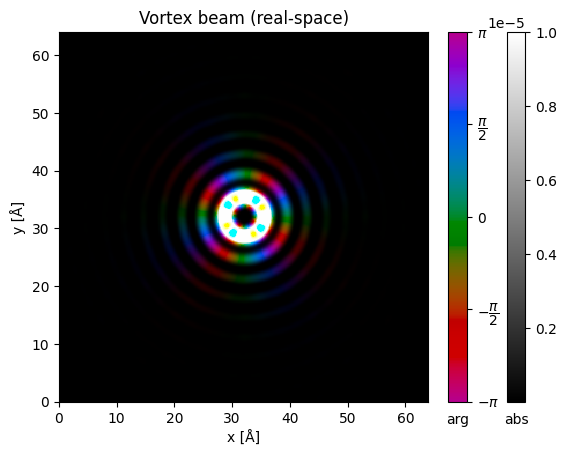

In [442]:
probe_vortex.build().complex_images().crop((64,64),(32,32)).show(vmax = 1e-5, cbar=True, title="Vortex beam (real-space)");

## TEM phase plates

Sample: [Covid spike protein](https://www.rcsb.org/structure/3JCL)

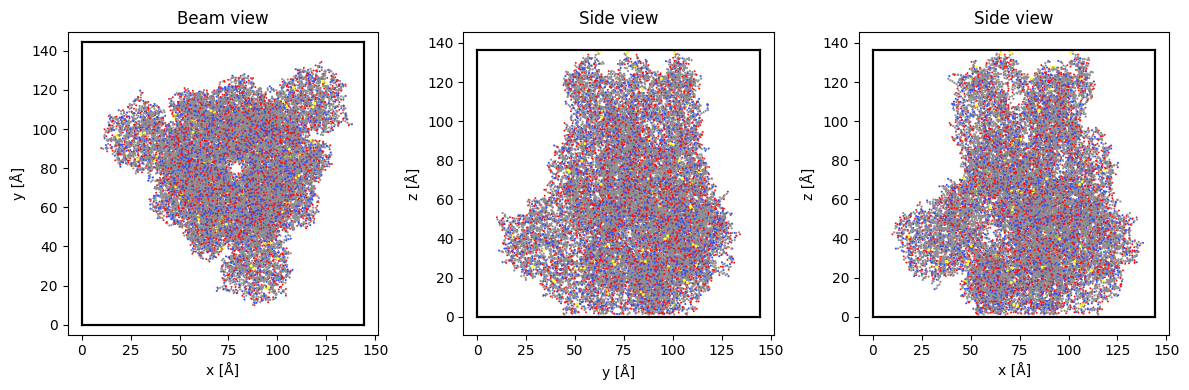

In [19]:
#load protein
atoms = read('data/3jcl.xyz')
atoms.positions[:,0] -= atoms.positions[:,0].min()
atoms.positions[:,1] -= atoms.positions[:,1].min()
atoms.positions[:,2] -= atoms.positions[:,2].min()

atoms.cell[0][0] = atoms.positions[:,0].max()
atoms.cell[1][1] = atoms.positions[:,1].max()
atoms.cell[2][2] = atoms.positions[:,2].max()

atoms.center(vacuum = 10, axis = (0,1))
atoms.cell[0][0] = atoms.cell[1][1]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

abtem.show_atoms(atoms, ax=ax1, title="Beam view", linewidth=0)
abtem.show_atoms(atoms, ax=ax2, plane="yz", title="Side view", linewidth=0)
abtem.show_atoms(atoms, ax=ax3, plane="xz", title="Side view", linewidth=0)

fig.tight_layout();

[########################################] | 100% Completed | 2.90 ss


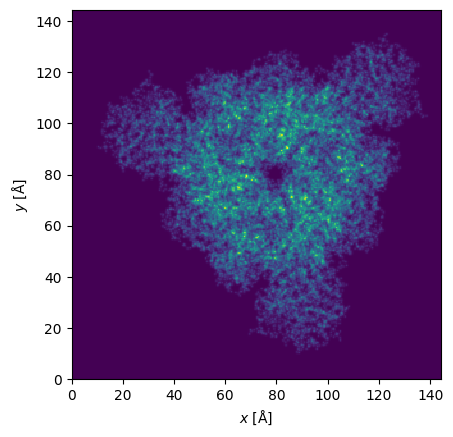

In [21]:
#make potential
potential = abtem.Potential(
    atoms, 
    sampling = 0.5,
)
potential.project().show();

In [22]:
#calcualte exit waves
wave = abtem.waves.PlaneWave(energy=300e3)
exit_waves = wave.multislice(potential).compute()

[########################################] | 100% Completed | 5.37 ss


In [23]:
#CTFs for in focus and defocus
ctf_defocused = abtem.CTF(
    aberration_coefficients={'C10': -10000}, 
    semiangle_cutoff = 10,
    energy=300e3)

ctf_infocus = abtem.CTF(
    aberration_coefficients={'C10': 0}, 
    semiangle_cutoff = 10,
    energy=300e3)

dose = 100

In [24]:
#calcualte in focus and defocus images
image_defocus = exit_waves.apply_ctf(ctf_defocused)
image_infocus = exit_waves.apply_ctf(ctf_infocus)

intensity_defocus = image_defocus.intensity()
intensity_infocus = image_infocus.intensity()

noisy_defocus = intensity_defocus.poisson_noise(dose)
noisy_infocus = intensity_defocus.poisson_noise(dose)

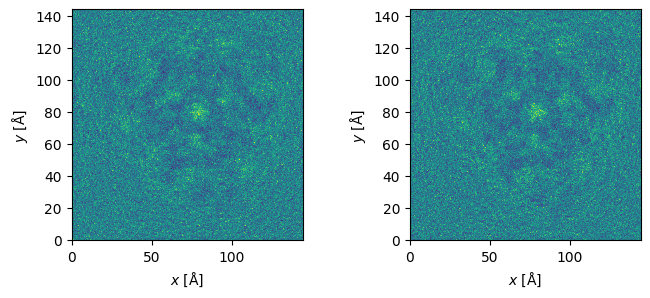

In [25]:
#The defocused probe provides better transer of information
plot_range = [55, 1]

fig, ax = plt.subplots(1,2, figsize = (8,3))
noisy_defocus.show(ax= ax[0], vmax = plot_range[0], vmin = plot_range[1])
noisy_infocus.show(ax= ax[1], vmax = plot_range[0], vmin = plot_range[1])

In [26]:
#create zernike probe
class Diverse_CTF(abtem.transfer.CTF):
    """
    child class of abTEM contrast transfer function
    """
    def __init__(
        self, 
        energy,
        defocus, 
        cutoff = 10/1000, 
        *args, 
        **kwargs):
        """
        Parameters
        ----------
       
        """
         
        self.cutoff = cutoff
        self.E0 = energy
        
        super().__init__(
            energy = energy,
            defocus = defocus,
            *args, 
            **kwargs)
        
    def evaluate(self, 
                 alpha, 
                 phi):
        """
        Parameters
        ----------

        Returns
        -------
        CTF: Union[float, np.ndarray]
            custom contrast transfer function 
        """
        from abtem.device import get_array_module, get_device_function

        xp = get_array_module(alpha)
        
        CTF = self.evaluate_aperture(alpha,phi)*self.evaluate_aberrations(alpha, phi)

        zernike = np.zeros_like(alpha) 
        zernike[alpha > self.cutoff] =np.pi/2
        CTF *= xp.exp(1j * zernike)            
            
        return CTF

In [27]:
zernike_ctf = Diverse_CTF(
    300e3, 
    defocus = 0,
    cutoff=1/1000, 
    semiangle_cutoff = 10,
)

In [42]:
zernike = abtem.transfer.RadialPhasePlate(
    num_rings = 1,
    central_semiangle = 1,
    phase_shift = np.pi,
    semiangle_cutoff = 10, 
    energy = 300e3,
#    extent = extent, 
#    sampling = sampling
)

In [43]:
#plot complex CTF
#zernike_ctf.complex_images(exit_waves.grid).show(cbar = True)

In [44]:
image_wave_zernike = exit_waves.apply_ctf(zernike)

intensity_zernike = image_wave_zernike.intensity()

noisy_zernike = intensity_zernike.poisson_noise(dose)

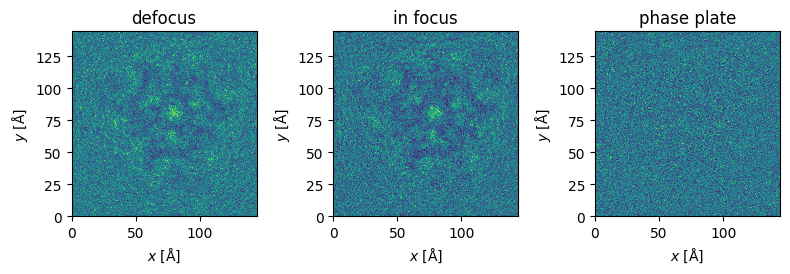

In [45]:
#zernike provides best transfer of information
plot_range = [55, 1]

fig, ax = plt.subplots(1,3, figsize = (8,3))
noisy_defocus.show(ax = ax[0])#, vmax = plot_range[0], vmin = plot_range[1])
noisy_infocus.show(ax = ax[1])#, vmax = plot_range[0], vmin = plot_range[1])
noisy_zernike.show(ax = ax[2])#, vmax = plot_range[0], vmin = plot_range[1])


ax[0].set_title('defocus')
ax[1].set_title('in focus')
ax[2].set_title('phase plate') 
plt.tight_layout()